In [1]:
import pandas as pd

In [2]:
file_path = './Dataset/Dementia Prediction Dataset.csv'

df = pd.read_csv(file_path)

/var/folders/f8/s7_j6j8j5y5dccj4rpr3xjgw0000gn/T/ipykernel_7720/512836769.py:3: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 1. Load Data & Define Target ---

# IMPORTANT: Replace 'nacc_dataset.csv' with the path to the CSV file you downloaded.

# IMPORTANT: Replace 'dementia_label' with the actual name of the 
# [cite_start]binary target column in your CSV file. [cite: 1380]
TARGET_COLUMN = 'DEMENTED'

try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: Data file not found at '{file_path}'")
    print("Please download the dataset and update the file_path variable.")
    # Creating a small dummy dataset for demonstration if file isn't found
    data = pd.DataFrame({
        'NACCAGE': [65, 70, 80, 75, 999], 'SEX': [1, 2, 1, 2, 1], 'EDUC': [12, 16, 8, 20, 99],
        'MARISTAT': [1, 2, 1, 5, 9], 'RACE': [1, 1, 2, 5, 99], 'INRELTO': [1, 2, 9, 3, 1],
        'CVHATT': [0, 1, 2, 0, 9], 'CBSTROKE': [0, 0, 1, 0, 9], 'DIABETES': [0, 2, 1, 0, 9],
        'HYPERTEN': [1, 1, 0, 0, 9], 'HYPERCHO': [1, 0, 2, 9, 0], 'TBI': [0, 0, 0, 0, 9], 
        'DEP2YRS': [0, 1, 0, 0, 9], 'NACCBMI': [25.1, 28.9, 32.0, 22.4, 888.8],
        'dementia_label': [0, 1, 1, 0, 1]
    })
    TARGET_COLUMN = 'dementia_label'

print(f"Original data shape: {data.shape}")

# --- 2. Define Feature Sets ---
# Based on hackathon rules: A1, A2, A5, B1 are allowed.

# Numerical features that will be imputed (median) and scaled
numeric_features = [
    'NACCAGE',  # Subject's age [cite: 26]
    'EDUC',     # Subject's years of education [cite: 24]
    'NACCBMI'   # Subject's Body Mass Index [cite: 38]
]

# Categorical features that will be imputed (most frequent) and one-hot encoded
categorical_features = [
    'SEX',      # Subject's sex [cite: 24]
    'MARISTAT', # Marital status [cite: 26]
    'RACE',     # Subject's race [cite: 24]
    'INRELTO'   # Co-participant's relationship to subject [cite: 27]
]

# [cite_start]Self-reported health history (Form A5) [cite: 32, 34, 36]
# We will binarize these and engineer a new feature
health_history_features = [
    'CVHATT',   # Heart attack
    'CBSTROKE', # Stroke
    'DIABETES', # Diabetes
    'HYPERTEN', # Hypertension
    'HYPERCHO', # Hypercholesterolemia
    'TBI',      # Traumatic Brain Injury
    'DEP2YRS'   # Depression in last 2 years
]

# --- 3. Clean Missing/Unknown Values ---
# We replace all non-standard "missing" or "unknown" codes with np.nan
# This is critical for scikit-learn's imputers to work.
# You must check the data dictionary for all features you add!
missing_values_map = {
    'NACCAGE': [999],
    'EDUC': [99],               # [cite: 367]
    'NACCBMI': [888.8],         # [cite: 1118]
    'MARISTAT': [9],            # [cite: 377]
    'RACE': [99],               # [cite: 295]
    'INRELTO': [9],             # (9 is a common 'unknown' code)
    # For Form A5, 9 means "Unknown"
    'CVHATT': [9], 'CBSTROKE': [9], 'DIABETES': [9], 'HYPERTEN': [9],
    'HYPERCHO': [9], 'TBI': [9], 'DEP2YRS': [9]
}

for col, missing_vals in missing_values_map.items():
    if col in data.columns:
        data[col] = data[col].replace(missing_vals, np.nan)

print("Replaced special 'missing' codes with NaN.")

# --- 4. Feature Engineering ---

# 4a. Binarize Health History
# We map 0=Absent to 0, and 1=Recent/2=Remote to 1 (Present).
# NaNs will stay NaN and be imputed later.
for col in health_history_features:
    if col in data.columns:
        data[col] = data[col].map({0: 0, 1: 1, 2: 1})

# 4b. Create 'ComorbidityCount'
# This counts how many conditions are present.
# We fill NaNs with 0 (assuming 'unknown' means 'absent') before summing.
# This is a key decision you must justify in your report.
data['ComorbidityCount'] = data[health_history_features].fillna(0).sum(axis=1)

# Add our new engineered feature to the numeric list
numeric_features.append('ComorbidityCount')

print("Engineered 'ComorbidityCount' feature.")

# --- 5. Separate Features (X) and Target (y) ---

# Check if target column exists before proceeding
if TARGET_COLUMN not in data.columns:
    print(f"FATAL ERROR: Target column '{TARGET_COLUMN}' not found!")
    print("Please update the TARGET_COLUMN variable at the top of the script.")
else:
    # 'X' contains all the feature columns we defined
    X = data[numeric_features + categorical_features]
    
    # 'y' contains only the target variable
    y = data[TARGET_COLUMN]

    # --- 6. Define Preprocessing Pipelines ---

    # This pipeline imputes numerical NaNs with the median value, then scales the data.
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # This pipeline imputes categorical NaNs with the most frequent value, 
    # then one-hot encodes the features.
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Use ColumnTransformer to apply the correct pipeline to the correct columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop' # Drop any columns we didn't explicitly select
    )

    # --- 7. Apply Preprocessing ---
    # .fit_transform() learns the imputing/scaling strategies and applies them
    X_processed = preprocessor.fit_transform(X)

    # Get the new feature names (e.g., after one-hot encoding)
    feature_names = preprocessor.get_feature_names_out()
    
    # Convert the processed data back to a DataFrame for easier inspection
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

    print("\n--- Preprocessing Complete ---")
    print(f"Shape of processed features (X): {X_processed.shape}")
    print(f"Shape of target (y): {y.shape}")

    print("\nProcessed features (first 5 rows):")
    print(X_processed_df.head())

    print("\nProcessed feature names:")
    print(list(feature_names))

    # X_processed (as a NumPy array) and y (as a Pandas Series) are now ready 
    # to be split and fed into your models.
    #
    # Example next step:
    # from sklearn.model_selection import train_test_split
    # X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

/var/folders/f8/s7_j6j8j5y5dccj4rpr3xjgw0000gn/T/ipykernel_7720/945715421.py:17: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Original data shape: (195196, 1024)
Replaced special 'missing' codes with NaN.
Engineered 'ComorbidityCount' feature.

--- Preprocessing Complete ---
Shape of processed features (X): (195196, 26)
Shape of target (y): (195196,)

Processed features (first 5 rows):
   num__NACCAGE  num__EDUC  num__NACCBMI  num__ComorbidityCount  cat__SEX_1.0  \
0     -0.424061   0.136566      0.831051               1.549393           1.0   
1     -0.327002   0.136566      0.683279              -0.858180           1.0   
2     -0.812297   0.136566      0.074805              -0.858180           1.0   
3     -1.103474   0.136566      0.222577              -0.858180           0.0   
4      0.255351  -1.107783     -0.333743              -0.858180           1.0   

   cat__SEX_2.0  cat__MARISTAT_1.0  cat__MARISTAT_2.0  cat__MARISTAT_3.0  \
0           0.0                1.0                0.0                0.0   
1           0.0                1.0                0.0                0.0   
2           0.0       

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# --- 1. Split Data ---
# (Assuming your processed data is 'X_processed' and 'y' is your target)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, 
    y, 
    test_size=0.2,    # 20% for testing
    random_state=42,  # For reproducible results
    stratify=y        # Ensures balanced classes in train/test sets
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (156156, 26)
Testing data shape: (39040, 26)


In [6]:
# --- 2. Train Baseline Model: Logistic Regression ---
print("--- Training Logistic Regression ---")

# Initialize the model (max_iter=1000 to help convergence)
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
lr_model.fit(X_train, y_train)

# --- Evaluate the Baseline Model ---
print("\n--- Evaluating Logistic Regression ---")
lr_preds = lr_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, lr_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_preds))

--- Training Logistic Regression ---

--- Evaluating Logistic Regression ---
Accuracy: 0.7179

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82     27522
           1       0.56      0.20      0.30     11518

    accuracy                           0.72     39040
   macro avg       0.65      0.57      0.56     39040
weighted avg       0.68      0.72      0.67     39040



In [7]:
# --- 3. Train Main Model: Random Forest ---
print("--- Training Random Forest ---")

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# --- Evaluate the Main Model ---
print("\n--- Evaluating Random Forest ---")
rf_preds = rf_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_preds))

--- Training Random Forest ---

--- Evaluating Random Forest ---
Accuracy: 0.7225

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     27522
           1       0.54      0.42      0.47     11518

    accuracy                           0.72     39040
   macro avg       0.66      0.64      0.64     39040
weighted avg       0.71      0.72      0.71     39040



In [8]:
# --- 4. Get Model Insights (Feature Importance) ---
print("\n--- Feature Importances from Random Forest ---")

# Get importances from the trained model
importances = rf_model.feature_importances_

# (This requires the 'feature_names' variable from the preprocessing script)
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# This DataFrame is perfect for a chart in your final report!


--- Feature Importances from Random Forest ---
Top 10 Most Important Features:
num__NACCBMI             0.405435
num__NACCAGE             0.283275
num__EDUC                0.126696
num__ComorbidityCount    0.061864
cat__INRELTO_5.0         0.019199
cat__INRELTO_1.0         0.011962
cat__INRELTO_2.0         0.009742
cat__MARISTAT_1.0        0.008641
cat__RACE_1.0            0.007318
cat__INRELTO_-4.0        0.006933
dtype: float64


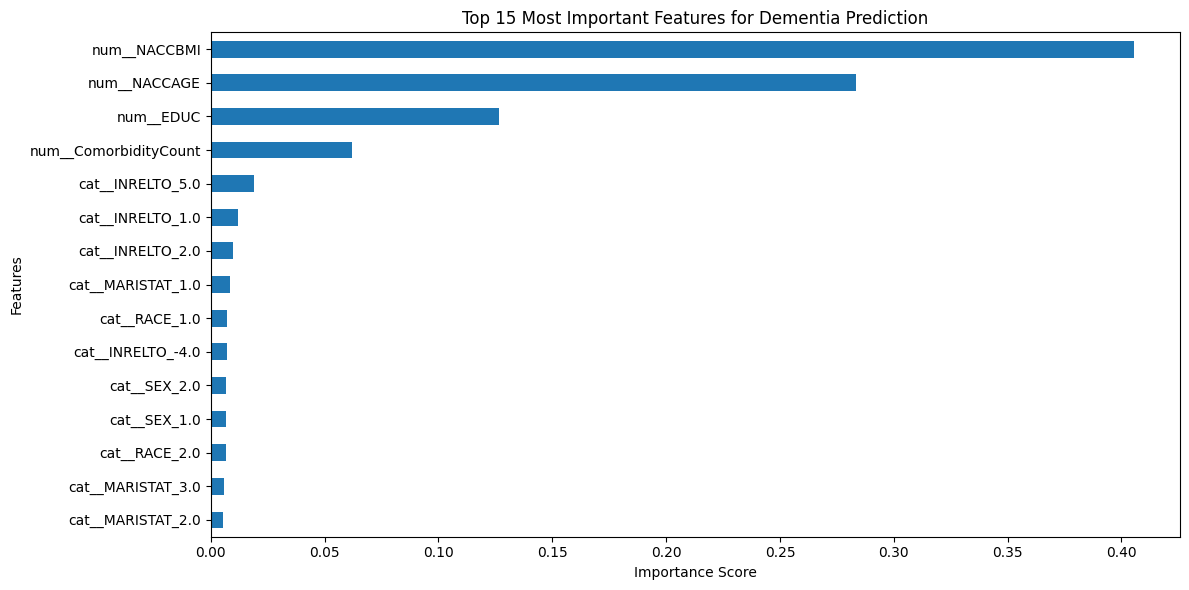

In [9]:
import matplotlib.pyplot as plt

# Create a bar plot of feature importances
plt.figure(figsize=(12, 6))
feature_importance_df.head(15).plot(kind='barh')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 15 Most Important Features for Dementia Prediction')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

/var/folders/f8/s7_j6j8j5y5dccj4rpr3xjgw0000gn/T/ipykernel_7720/2453921276.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')


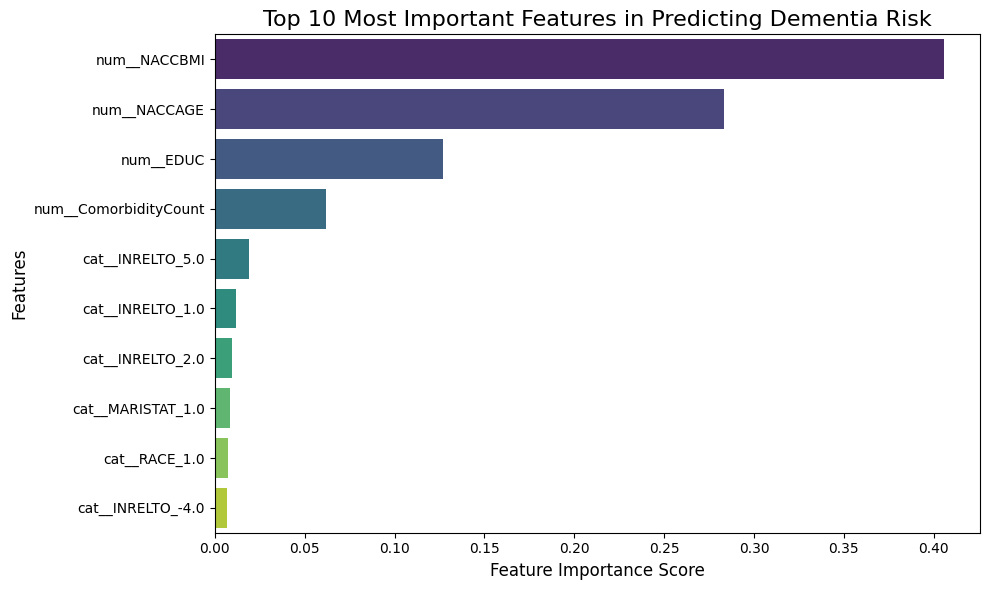

In [10]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except:
    print("Installing seaborn...")
    import os
    os.system("pip install seaborn")
    import seaborn as sns

# (This assumes your feature importance list is in the 'feature_importance_df' variable)

# Let's get the Top 10 features
top_10_features = feature_importance_df.head(10)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Top 10 Most Important Features in Predicting Dementia Risk', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()

# This command will save the plot as an image file you can put in your report
plt.savefig('feature_importance_plot.png')

# Show the plot in your notebook
plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV

# We will also need numpy to define the range of values to try
import numpy as np

In [12]:
# compare performance of different models already done in previous cells

rf_performance = accuracy_score(y_test, rf_preds)
lr_performance = accuracy_score(y_test, lr_preds)

print(f"Random Forest Accuracy: {rf_performance:.4f}")
print(f"Logistic Regression Accuracy: {lr_performance:.4f}")

Random Forest Accuracy: 0.7225
Logistic Regression Accuracy: 0.7179


# Using XGBoost

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# (This assumes your X_train, X_test, y_train, y_test are still in memory)

print("--- Training XGBoost Classifier ---")

# 1. Initialize the XGBClassifier
# We add 'use_label_encoder=False' and 'eval_metric='logloss'' 
# to use the latest standards and suppress warnings.
xgb_model = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

# 2. Train the model
xgb_model.fit(X_train, y_train)

# 3. Evaluate the model
print("\n--- Evaluating XGBoost Classifier ---")
xgb_preds = xgb_model.predict(X_test)

print(f"XGBoost Model Accuracy: {accuracy_score(y_test, xgb_preds):.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

--- Training XGBoost Classifier ---


/opt/anaconda3/envs/metal/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluating XGBoost Classifier ---
XGBoost Model Accuracy: 0.7394

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     27522
           1       0.62      0.31      0.41     11518

    accuracy                           0.74     39040
   macro avg       0.69      0.61      0.62     39040
weighted avg       0.72      0.74      0.71     39040



# Using Catboost

In [14]:
# Using CatBoost

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

print("--- Training CatBoost Classifier ---")
cat_model = CatBoostClassifier(
    random_seed=42,
    verbose=0  # Suppress training output
)
cat_model.fit(X_train, y_train)
print("\n--- Evaluating CatBoost Classifier ---")
cat_preds = cat_model.predict(X_test)
cat_performance = accuracy_score(y_test, cat_preds)
print(f"CatBoost Accuracy: {cat_performance:.4f}")

--- Training CatBoost Classifier ---

--- Evaluating CatBoost Classifier ---
CatBoost Accuracy: 0.7411


In [15]:
# compare performance of different models already done in previous cells

rf_performance = accuracy_score(y_test, rf_preds)
lr_performance = accuracy_score(y_test, lr_preds)
xg_performance = accuracy_score(y_test, xgb_preds)
cat_performance = accuracy_score(y_test, cat_preds)

print(f"Random Forest Accuracy: {rf_performance:.4f}")
print(f"Logistic Regression Accuracy: {lr_performance:.4f}")
print(f"XGBoost Accuracy: {xg_performance:.4f}")
print(f"CatBoost Accuracy: {cat_performance:.4f}")

Random Forest Accuracy: 0.7225
Logistic Regression Accuracy: 0.7179
XGBoost Accuracy: 0.7394
CatBoost Accuracy: 0.7411


In [16]:
# Features we have used so far:
print(
    f'Numerical features \n\t{numeric_features}' + 
    f'\nCategorical features \n\t{categorical_features}' + 
    f'\nHealth history features \n\t{health_history_features}' + 
    f'\nAdditional features \n\t{["ComorbidityCount"]}\n\t "Engineered Feature by using existing health history features such as CVHATT, CBSTROKE, DIABETES, HYPERTEN, HYPERCHO, TBI, DEP2YRS."'
)

Numerical features 
	['NACCAGE', 'EDUC', 'NACCBMI', 'ComorbidityCount']
Categorical features 
	['SEX', 'MARISTAT', 'RACE', 'INRELTO']
Health history features 
	['CVHATT', 'CBSTROKE', 'DIABETES', 'HYPERTEN', 'HYPERCHO', 'TBI', 'DEP2YRS']
Additional features 
	['ComorbidityCount']
	 "Engineered Feature by using existing health history features such as CVHATT, CBSTROKE, DIABETES, HYPERTEN, HYPERCHO, TBI, DEP2YRS."


In [20]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# (This assumes your X_train, X_test, y_train, y_test are still in memory)

print("--- Starting CatBoost Hyperparameter Tuning ---")

# 1. Create a "Pool" - CatBoost's native data format
train_pool = Pool(X_train, y_train)

# 2. Define the grid of parameters to try
# These are some of the most common parameters to tune
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]  # This is L2 regularization
}

# 3. Initialize the base model
cat_model_to_tune = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    eval_metric='Accuracy'  # We want to optimize for accuracy
)

# 4. Run the randomized search
# n_iter=10 means it will try 10 random combinations from your grid
# cv=3 means 3-fold cross-validation
randomized_search_result = cat_model_to_tune.randomized_search(
    param_grid,
    X=train_pool,
    n_iter=10,
    cv=3,
    verbose=False,
    plot=True
)

print("\n--- Tuning Complete ---")
print("Best Parameters found:")
print(randomized_search_result['params'])

# 5. Get the new, tuned model and evaluate it
best_cat_model = cat_model_to_tune

tuned_preds = best_cat_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, tuned_preds)

print(f"\nOriginal CatBoost Accuracy: {cat_performance:.4f}")
print(f"Tuned CatBoost Accuracy:  {tuned_accuracy:.4f}")

print("\nTuned CatBoost Classification Report:")
print(classification_report(y_test, tuned_preds))

--- Starting CatBoost Hyperparameter Tuning ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7357838115
bestIteration = 992


bestTest = 0.7414510758
bestIteration = 1476


bestTest = 0.743564293
bestIteration = 499


bestTest = 0.7392418033
bestIteration = 997


bestTest = 0.7451331967
bestIteration = 1268


bestTest = 0.7449731045
bestIteration = 375


bestTest = 0.743564293
bestIteration = 433


bestTest = 0.745517418
bestIteration = 999


bestTest = 0.7456454918
bestIteration = 724


bestTest = 0.7414510758
bestIteration = 1495

Training on fold [0/3]

bestTest = 0.7426661288
bestIteration = 676

Training on fold [1/3]

bestTest = 0.7412395297
bestIteration = 999

Training on fold [2/3]

bestTest = 0.7416956447
bestIteration = 989


--- Tuning Complete ---
Best Parameters found:
{'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 1000}

Original CatBoost Accuracy: 0.7411
Tuned CatBoost Accuracy:  0.7428

Tuned CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.84     

/var/folders/f8/s7_j6j8j5y5dccj4rpr3xjgw0000gn/T/ipykernel_7720/2328795095.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_feature_importance_df.values, y=cat_feature_importance_df.index, palette='viridis')


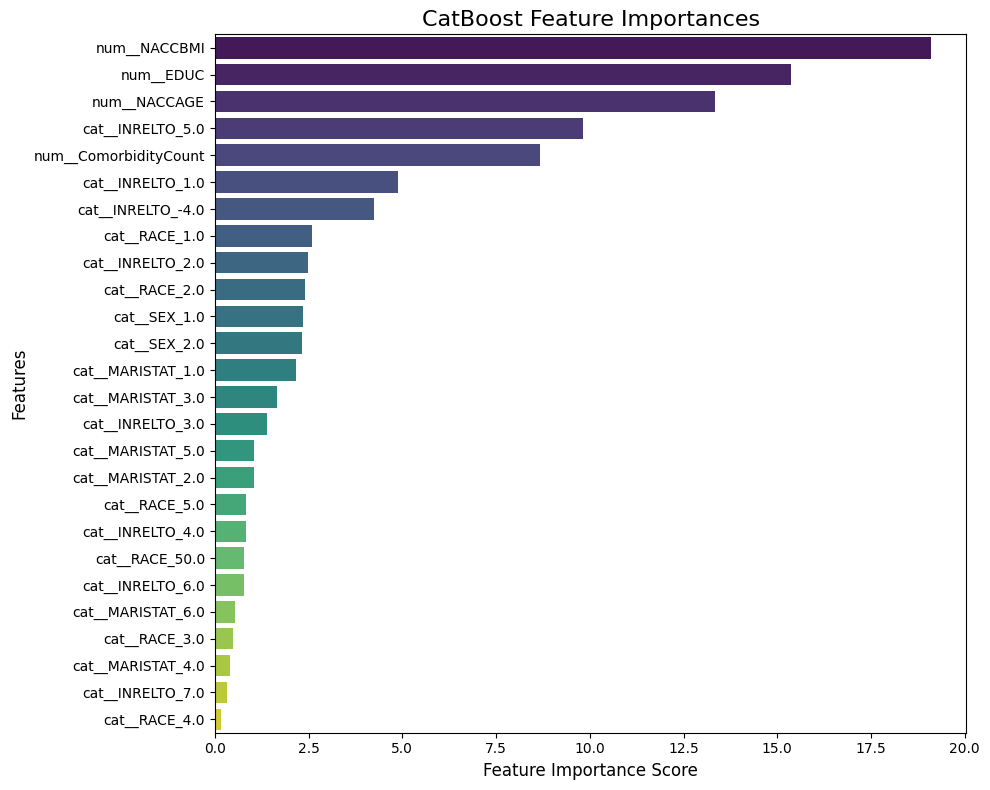


Top 10 Most Important Features (CatBoost):
num__NACCBMI             19.090393
num__EDUC                15.361151
num__NACCAGE             13.339038
cat__INRELTO_5.0          9.824977
num__ComorbidityCount     8.683953
cat__INRELTO_1.0          4.875783
cat__INRELTO_-4.0         4.249830
cat__RACE_1.0             2.597589
cat__INRELTO_2.0          2.473787
cat__RACE_2.0             2.394576
dtype: float64

Features with very low importance:
cat__MARISTAT_2.0    1.037227
cat__RACE_5.0        0.844138
cat__INRELTO_4.0     0.821512
cat__RACE_50.0       0.772535
cat__INRELTO_6.0     0.766544
cat__MARISTAT_6.0    0.538466
cat__RACE_3.0        0.482621
cat__MARISTAT_4.0    0.416584
cat__INRELTO_7.0     0.338586
cat__RACE_4.0        0.153765
dtype: float64


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (This assumes 'cat_model' is your original, non-tuned model
# and 'feature_names' is the list from your preprocessor)

# Get importances
importances = cat_model.get_feature_importance()

# Create a DataFrame for easy plotting
cat_feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the importances
plt.figure(figsize=(10, 8))
sns.barplot(x=cat_feature_importance_df.values, y=cat_feature_importance_df.index, palette='viridis')
plt.title('CatBoost Feature Importances', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig('catboost_feature_importance.png')
plt.show()

print("\nTop 10 Most Important Features (CatBoost):")
print(cat_feature_importance_df.head(10))

print("\nFeatures with very low importance:")
print(cat_feature_importance_df.tail(10))

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier

# (This assumes 'X_processed_df' is the DataFrame from your preprocessing script
# and 'y' is your target series)

# --- 1. Select features with importance > 1 ---
# (You can change this threshold based on your plot)
threshold = 1.0
features_to_keep = cat_feature_importance_df[cat_feature_importance_df > threshold].index

print(f"\nOriginal number of features: {len(feature_names)}")
print(f"Keeping {len(features_to_keep)} features with importance > {threshold}")

# --- 2. Create new X/y datasets ---
X_new = X_processed_df[features_to_keep]

# Split the NEW data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 3. Re-train the CatBoost model ---
print("\n--- Training CatBoost on SELECTED Features ---")
cat_model_new = CatBoostClassifier(
    random_seed=42,
    verbose=0
)

cat_model_new.fit(X_train_new, y_train_new)

# --- 4. Evaluate the new model ---
print("--- Evaluating NEW CatBoost Model ---")
new_preds = cat_model_new.predict(X_test_new)
new_accuracy = accuracy_score(y_test_new, new_preds)

print(f"Original CatBoost Accuracy: {cat_performance:.4f}")
print(f"New Model Accuracy (Feature Selection): {new_accuracy:.4f}")

if new_accuracy > cat_performance:
    print("\nSuccess! Feature selection improved the model.")
else:
    print("\nFeature selection did not improve the model. The original model is best.")

print("\nNew Model Classification Report:")
print(classification_report(y_test_new, new_preds))


Original number of features: 26
Keeping 17 features with importance > 1.0

--- Training CatBoost on SELECTED Features ---
--- Evaluating NEW CatBoost Model ---
Original CatBoost Accuracy: 0.7411
New Model Accuracy (Feature Selection): 0.7397

Feature selection did not improve the model. The original model is best.

New Model Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     27522
           1       0.62      0.30      0.40     11518

    accuracy                           0.74     39040
   macro avg       0.69      0.61      0.62     39040
weighted avg       0.72      0.74      0.71     39040



In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier

# (This assumes 'X_processed_df' is the DataFrame from your preprocessing script
# and 'y' is your target series)

# --- 1. Select features with importance > 1 ---
# (You can change this threshold based on your plot)
threshold = 0.5
features_to_keep = cat_feature_importance_df[cat_feature_importance_df > threshold].index

print(f"\nOriginal number of features: {len(feature_names)}")
print(f"Keeping {len(features_to_keep)} features with importance > {threshold}")

# --- 2. Create new X/y datasets ---
X_new = X_processed_df[features_to_keep]

# Split the NEW data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 3. Re-train the CatBoost model ---
print("\n--- Training CatBoost on SELECTED Features ---")
cat_model_new = CatBoostClassifier(
    random_seed=42,
    verbose=0
)

cat_model_new.fit(X_train_new, y_train_new)

# --- 4. Evaluate the new model ---
print("--- Evaluating NEW CatBoost Model ---")
new_preds = cat_model_new.predict(X_test_new)
new_accuracy = accuracy_score(y_test_new, new_preds)

print(f"Original CatBoost Accuracy: {cat_performance:.4f}")
print(f"New Model Accuracy (Feature Selection): {new_accuracy:.4f}")

if new_accuracy > cat_performance:
    print("\nSuccess! Feature selection improved the model.")
else:
    print("\nFeature selection did not improve the model. The original model is best.")

print("\nNew Model Classification Report:")
print(classification_report(y_test_new, new_preds))


Original number of features: 26
Keeping 22 features with importance > 0.5

--- Training CatBoost on SELECTED Features ---
--- Evaluating NEW CatBoost Model ---
Original CatBoost Accuracy: 0.7411
New Model Accuracy (Feature Selection): 0.7413

Success! Feature selection improved the model.

New Model Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     27522
           1       0.63      0.31      0.41     11518

    accuracy                           0.74     39040
   macro avg       0.69      0.61      0.62     39040
weighted avg       0.72      0.74      0.71     39040

